### Import Libraries

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

#import warnings
#warnings.simplefilter(action="ignore")

# Set all columns and rows to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Import Data

In [2]:
# Import the dataset
data = pd.read_csv('../datasets/data_features_with_lags.csv')

In [3]:
# Check the data
data.head()

,time,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends,Mean Temperature (°C)_lag28,Mean Temperature (°C)_lag51,Mean Wind Speed (km/h)_lag6,Mean Wind Speed (km/h)_lag22,Mean Wind Speed (km/h)_lag47,Maximum Temperature (°C)_10,Maximum Temperature (°C)_lag10,Max Wind Speed (km/h)_lag14,Max Wind Speed (km/h)_lag41,Minimum Temperature (°C)_lag49,s_ratio,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725411,0,0,1,0,0,0,0,0,0,0,0
1,2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725367,0,0,1,0,0,0,0,0,0,0,0
2,2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725189,0,0,1,0,0,0,0,0,0,0,0
3,2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725087,0,0,1,0,0,0,0,0,0,0,0
4,2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.712189,0,0,0,1,0,0,0,0,0,0,0


In [4]:
# Check the shape of the data
data.shape

(257, 35)

In [6]:
# Look at the datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   time                            257 non-null    object 
 1   dengue_cases                    257 non-null    int64  
 2   denv_1                          257 non-null    float64
 3   denv_2                          257 non-null    float64
 4   denv_3                          257 non-null    float64
 5   denv_4                          257 non-null    float64
 6   Mean Temperature (°C)           257 non-null    float64
 7   Mean Wind Speed (km/h)          257 non-null    float64
 8   Daily Rainfall Total (mm)       257 non-null    float64
 9   Maximum Temperature (°C)        257 non-null    float64
 10  Max Wind Speed (km/h)           257 non-null    float64
 11  Minimum Temperature (°C)        257 non-null    float64
 12  google_trends                   257 

### Date Processing

The date feature is currently an object time. We will be converting it into a dateTime format.

In [7]:
# Convert the date column into dateTime format
data['time'] = pd.to_datetime(data['time'])

In [8]:
# Set the time as the index
data = data.set_index('time')

In [9]:
# Check the data 
data.head()

,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends,Mean Temperature (°C)_lag28,Mean Temperature (°C)_lag51,Mean Wind Speed (km/h)_lag6,Mean Wind Speed (km/h)_lag22,Mean Wind Speed (km/h)_lag47,Maximum Temperature (°C)_10,Maximum Temperature (°C)_lag10,Max Wind Speed (km/h)_lag14,Max Wind Speed (km/h)_lag41,Minimum Temperature (°C)_lag49,s_ratio,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725411,0,0,1,0,0,0,0,0,0,0,0
2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725367,0,0,1,0,0,0,0,0,0,0,0
2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725189,0,0,1,0,0,0,0,0,0,0,0
2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725087,0,0,1,0,0,0,0,0,0,0,0
2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.712189,0,0,0,1,0,0,0,0,0,0,0


In [10]:
# Drop NA values
data.dropna(inplace=True)

In [11]:
data.drop(columns=['denv_1', 'denv_2', 'denv_3', 'denv_4'], inplace=True)

In [12]:
data.drop(columns=['month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
                   'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
                  'month_12'], inplace=True)

In [13]:
data.drop(columns=['Mean Wind Speed (km/h)', 'Maximum Temperature (°C)', 'Max Wind Speed (km/h)', 'Minimum Temperature (°C)'], inplace=True)

### Train/Test Split

In [14]:
data.iloc[143] #last index for 2021

dengue_cases                      76.000000
Mean Temperature (°C)             27.785714
Daily Rainfall Total (mm)          1.514286
google_trends                     15.000000
Mean Temperature (°C)_lag28       28.757143
Mean Temperature (°C)_lag51       25.971429
Mean Wind Speed (km/h)_lag6        6.057143
Mean Wind Speed (km/h)_lag22       9.714286
Mean Wind Speed (km/h)_lag47      11.357143
Maximum Temperature (°C)_10       33.200000
Maximum Temperature (°C)_lag10    33.200000
Max Wind Speed (km/h)_lag14       44.400000
Max Wind Speed (km/h)_lag41       40.700000
Minimum Temperature (°C)_lag49    23.300000
s_ratio                            0.729691
Name: 2021-12-26 00:00:00, dtype: float64

In [15]:
143/206 #We will have a 70-30 train test split

0.6941747572815534

In [16]:
train = data.iloc[:143]
test = data.iloc[143:]

In [17]:
train.shape

(143, 15)

In [18]:
test.shape

(63, 15)

Overall, this is about a 30% train test split:
* Train: 70% of data
* Test: 30% of data

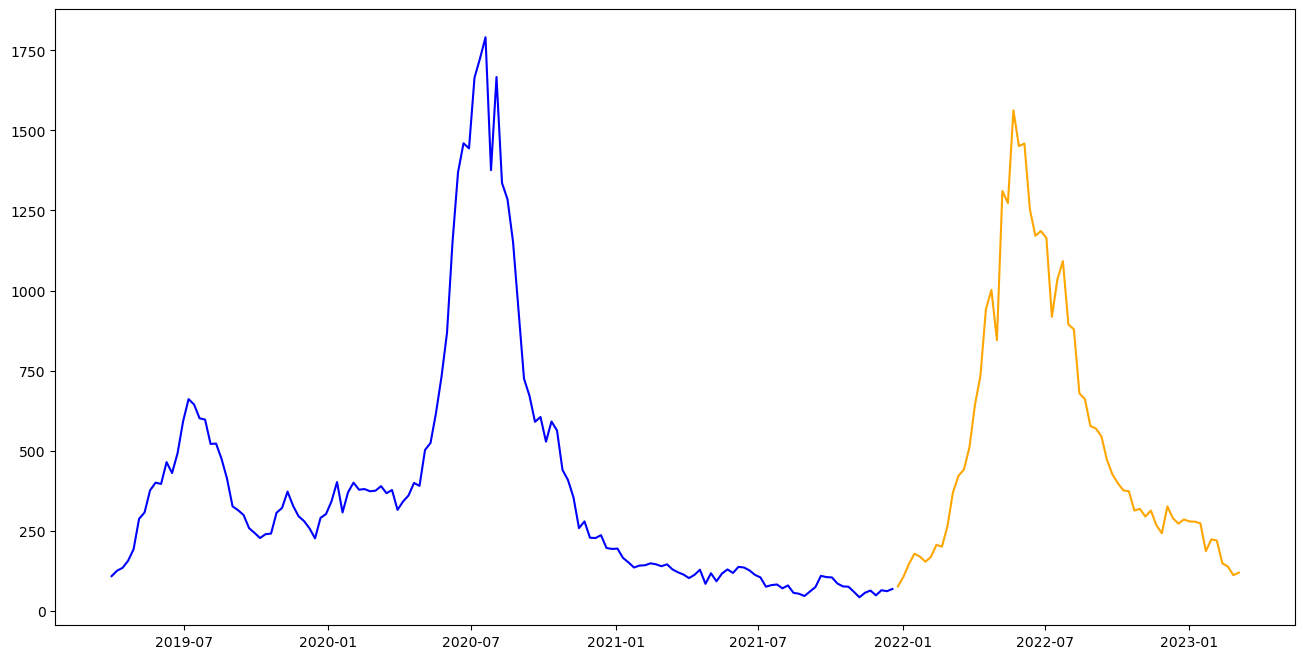

In [19]:
# Time series plot of the train and test data
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    plt.plot(train['dengue_cases'], c='blue')
    plt.plot(test['dengue_cases'], c='orange');
    
train_test_plot(train, test)

### Stationarity Test

We will use the stationarity test to identify the $d$ parameter for the ARIMA model

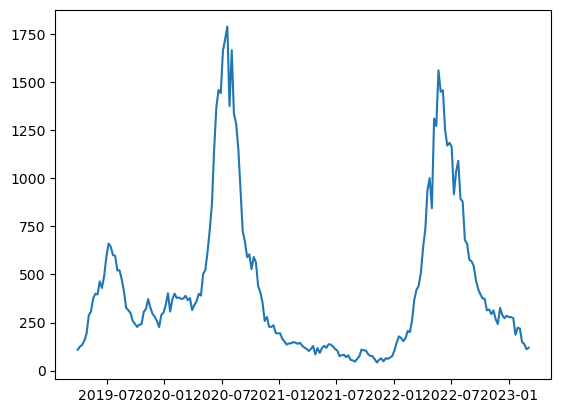

In [20]:
# Plot the data
plt.plot(data['dengue_cases']);

The time series of the dengue cases is clearly not stationary

In [21]:
# Instantiate a new dataframe for the difference information
diff = pd.DataFrame()

In [22]:
# Calculate the first difference of the dengue cases
diff['first_diff_dengue'] = data['dengue_cases'].diff()

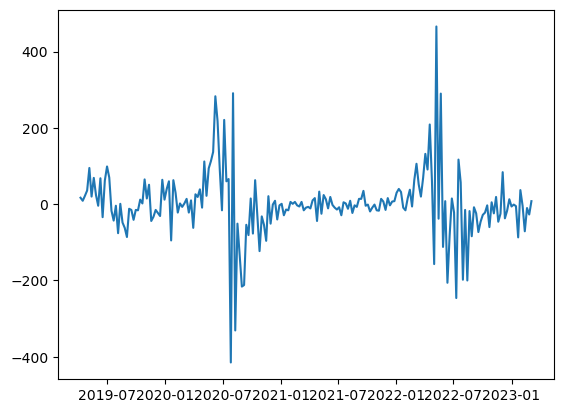

In [23]:
# Plot the first difference of the dengue cases
plt.plot(diff['first_diff_dengue']);

From the plot above, we can see that when the data is differenced once, the data is stationary. 

#### Augmented Dickey-Fuller Test

Let's also use the ADF test to test for Stationarity

In [24]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [25]:
# Run the ADF test on the original dengue data
interpret_dftest(adfuller(data['dengue_cases']))

Test Statistic   -3.437088
p-value           0.009758
dtype: float64

The p-value is above 0.05, hence this data is not stationary.

In [26]:
# Run the ADF test on the differenced dengue data
interpret_dftest(adfuller(data['dengue_cases'].diff().dropna()))

Test Statistic   -4.678026
p-value           0.000093
dtype: float64

The p-value is below 0.05 and we can conclude that the once differenced data is stationary. This is also in line with the differenced data plot. Hence, we can set the $d$ value to $1$.

### Finding the $p$ and $q$ values

We can use a ACF and PACF plot to find the $p$ and $q$ values.

#### ACF and PACF Plot for $p$ value

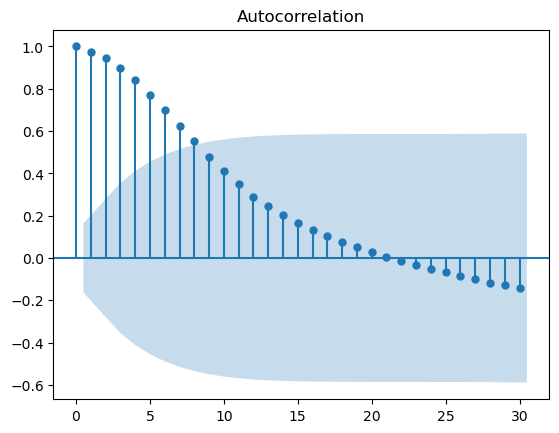

In [27]:
# Generate autocorrelation plot on training data.
plot_acf(train['dengue_cases'], lags = 30);

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


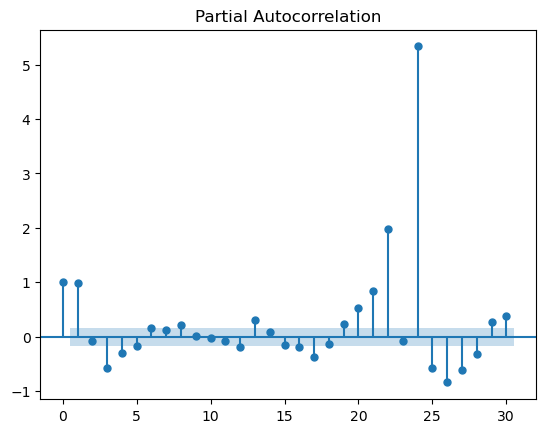

In [28]:
# Generate partial autocorrelation plot on training data.
plot_pacf(train['dengue_cases'], lags = 30);

The first lag of the ACF plot is also positive. There is also a sharp cut off in the PACF plot after the second lag. Hence, we can take the next lag of the PACF as the $p$ value and set it to $3$. 

As the $AR$ and $MA$ terms might work against each other and we were able to identify the $p$ value, we will set the $q$ value as $0$.  

### ARIMA Model (3, 1, 0)

Next, we can fit the ARIMA model and run the prediction.

In [29]:
# Instantiate best model.
arima = ARIMA(endog=train['dengue_cases'], order=(3, 1, 0))

# Fit ARIMA model.
model = arima.fit()

# Generate predictions based on test set
#preds = model.predict(start=195, end=256)
preds = model.predict(start=test.index[0], end=test.index[-1])

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN

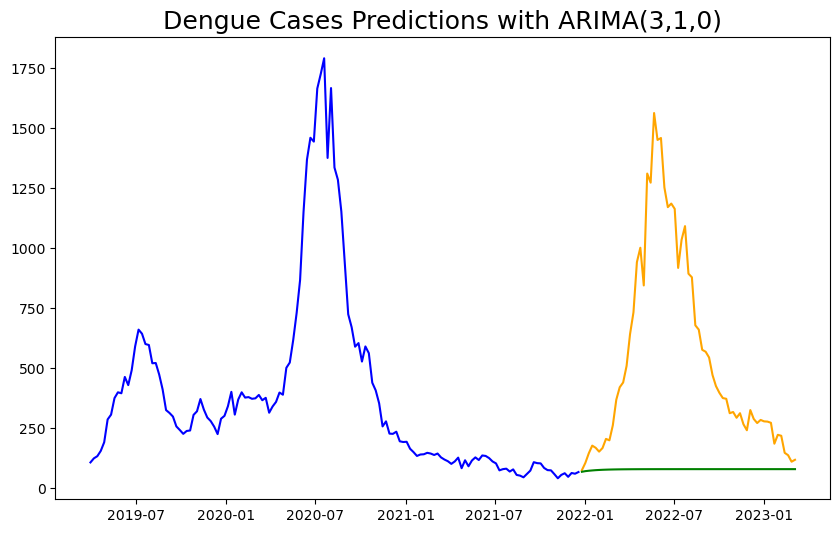

In [30]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMA(3,1,0)', fontsize=18)
plt.show();

In [31]:
# Evaluate the predictions MSE
mean_squared_error(test['dengue_cases'], preds)

380110.4238439434

In [32]:
# Evaluate the predictions with mean error
mean_squared_error(test['dengue_cases'], preds, squared=False)

616.5309593556055

In [33]:
# Evaluation of the model
error = round(mean_squared_error(test['dengue_cases'], preds, squared=True), 0)
print(f'Minimum Dengue Cases: {round(data["dengue_cases"].min(),0)}')
print(f'Maximum Dengue Cases: {round(data["dengue_cases"].max(),0)}')

print(f'MSE relative to minimum values in dengue cases: {round(error / data["dengue_cases"].min(),0)}.')
print(f'MSE relative to maximum values in dengue cases: {round(error / data["dengue_cases"].max(),0)}.')

Minimum Dengue Cases: 42
Maximum Dengue Cases: 1791
MSE relative to minimum values in dengue cases: 9050.0.
MSE relative to maximum values in dengue cases: 212.0.


Looking at the MSE values as well as the ratio of the mean squared error to the minimum and maximum values in the dengue cases, we can see that the model is not very good. 

#### Residual Plot

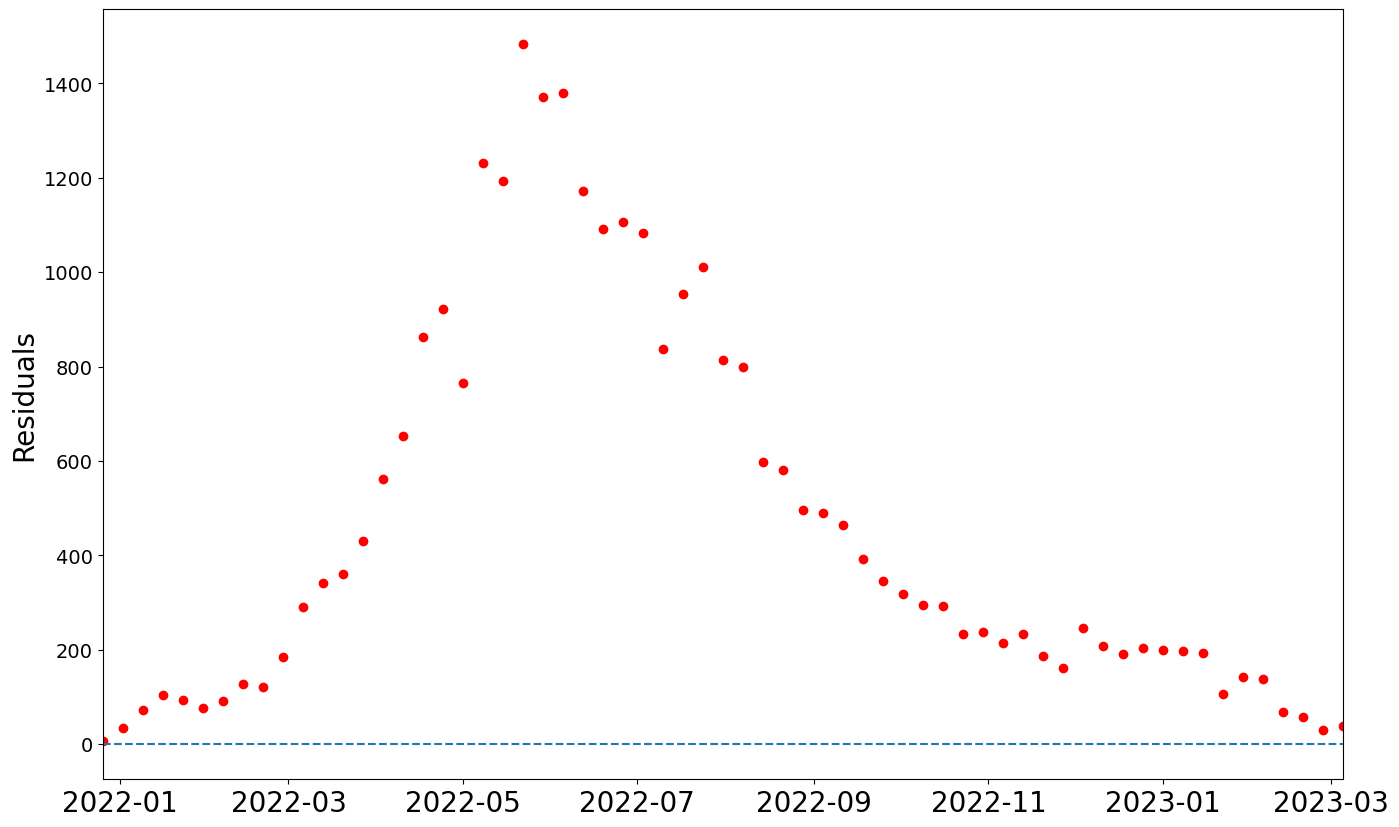

In [34]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['dengue_cases'].values - preds.values

# Generate scatterplot of residuals.
plt.scatter(test['dengue_cases'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['dengue_cases'].index.min(),
           xmax = test['dengue_cases'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['dengue_cases'].index.min(), test['dengue_cases'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

From the residual plot, we can see that the prediction is off to a high degree.

### ARIMAX

In [35]:
# Instantiate best model.
arimax = ARIMA(endog=train['dengue_cases'], order=(1, 1, 2), 
               exog=train.drop(columns=['dengue_cases']))

# Fit ARIMA model.
model = arimax.fit()

# Generate predictions based on test set.
preds = model.predict(start=test.index[0], end=test.index[-1], exog=test.drop(columns=['dengue_cases']))

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN

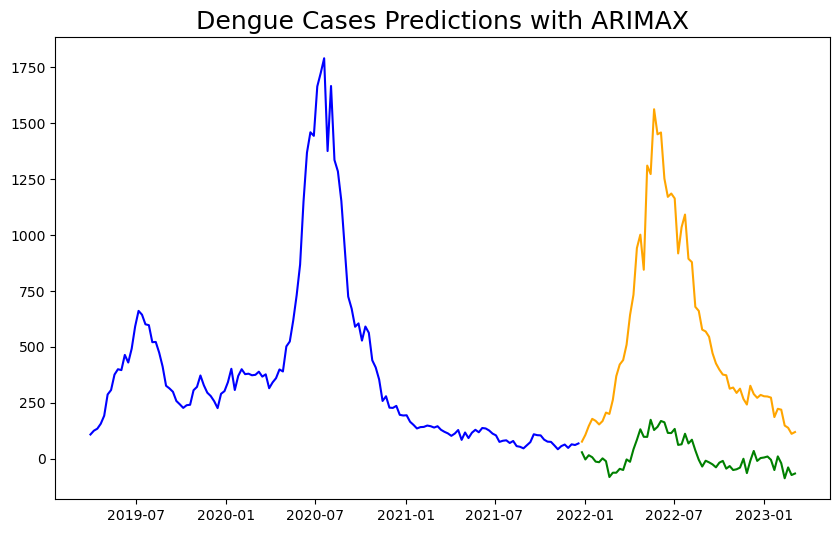

In [36]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX', fontsize=18)
plt.show();

In [37]:
# Evaluate the predictions MSE
mean_squared_error(test['dengue_cases'], preds)

400298.5612864728

In [38]:
# Evaluate the predictions with mean error
mean_squared_error(test['dengue_cases'], preds, squared=False)

632.6915214276803

#### Residual Plot

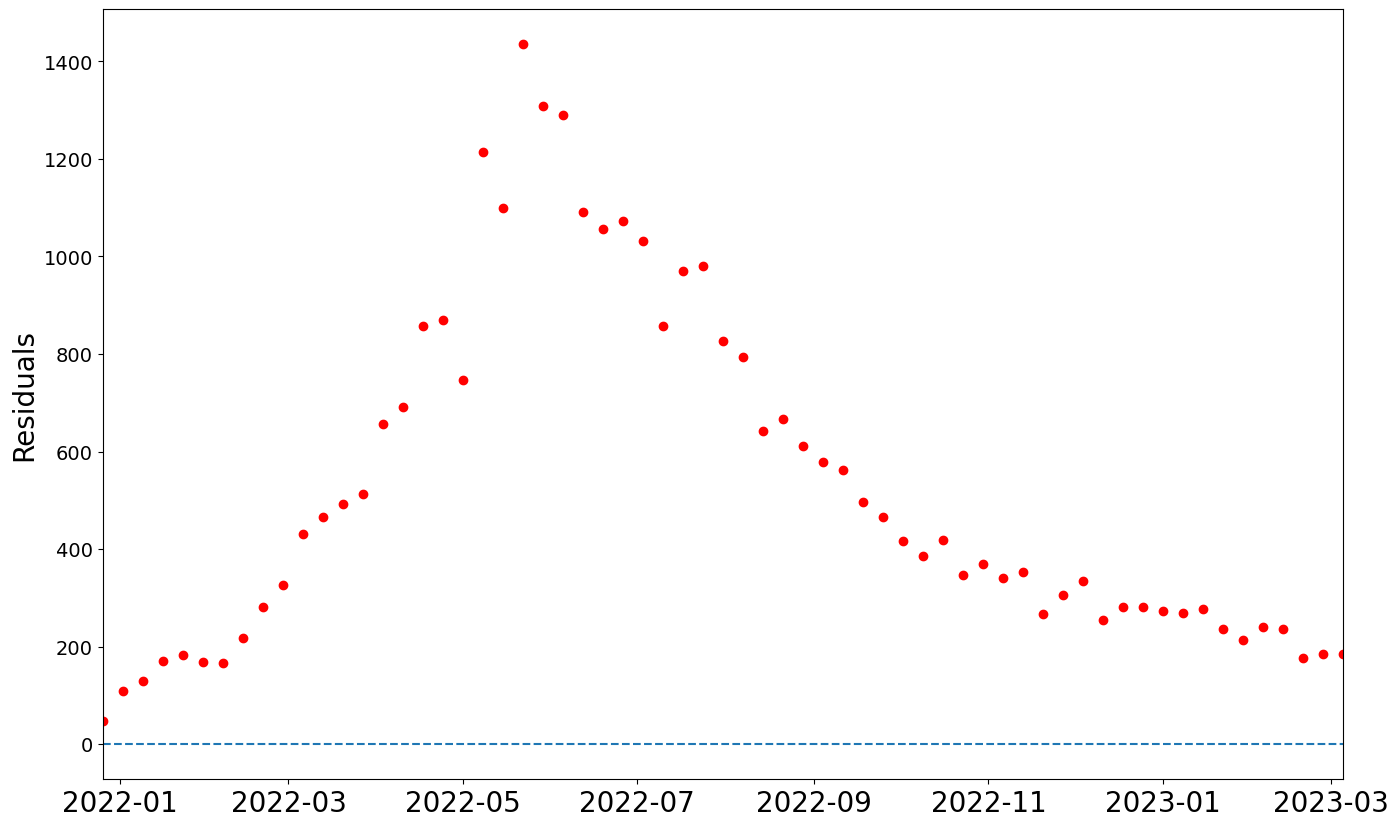

In [39]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['dengue_cases'].values - preds.values

# Generate scatterplot of residuals.
plt.scatter(test['dengue_cases'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['dengue_cases'].index.min(),
           xmax = test['dengue_cases'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['dengue_cases'].index.min(), test['dengue_cases'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

### SARIMAX Model without exogenous variables

In [40]:
%%time
sarimax = SARIMAX(endog=train['dengue_cases'],
                dates=train.index,
                order=(1,1,2),
                seasonal_order=(1,1,0,51),
                enforce_stationarity=False, # speed up model fitting
                enforce_invertibility=False # speed up model fitting
               )

model = sarimax.fit(maxiter=50, method='lbfgs')

preds = model.predict(start=test.index[0], end=test.index[-1])

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58110D+00    |proj g|=  3.27660D-02

At iterate    5    f=  1.57588D+00    |proj g|=  2.09002D-03

At iterate   10    f=  1.56508D+00    |proj g|=  1.83853D-02
  ys=-2.930E-04  -gs= 3.789E-03 BFGS update SKIPPED

At iterate   15    f=  1.51448D+00    |proj g|=  1.39822D-01

At iterate   20    f=  1.40662D+00    |proj g|=  9.03741D-02

At iterate   25    f=  1.39889D+00    |proj g|=  6.22864D-03

At iterate   30    f=  1.39556D+00    |proj g|=  6.61901D-02

At iterate   35    f=  1.38059D+00    |proj g|=  5.62380D-02

At iterate   40    f=  1.37294D+00    |proj g|=  1.13706D-02

At iterate   45    f=  1.37289D+00    |proj g|=  7.91328D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy search

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


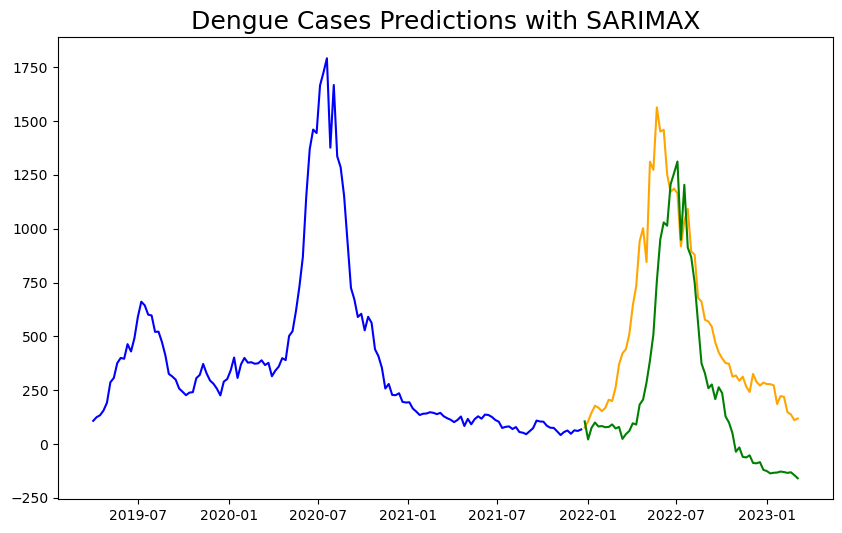

In [41]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds, color = 'green')

plt.title(label = 'Dengue Cases Predictions with SARIMAX', fontsize=18)
plt.show();

In [42]:
# Evaluate the predictions MSE
mean_squared_error(test['dengue_cases'], preds)

136018.5753986683

In [43]:
# Evaluate the predictions with mean error
mean_squared_error(test['dengue_cases'], preds, squared=False)

368.8069622426728

#### Residual Plot

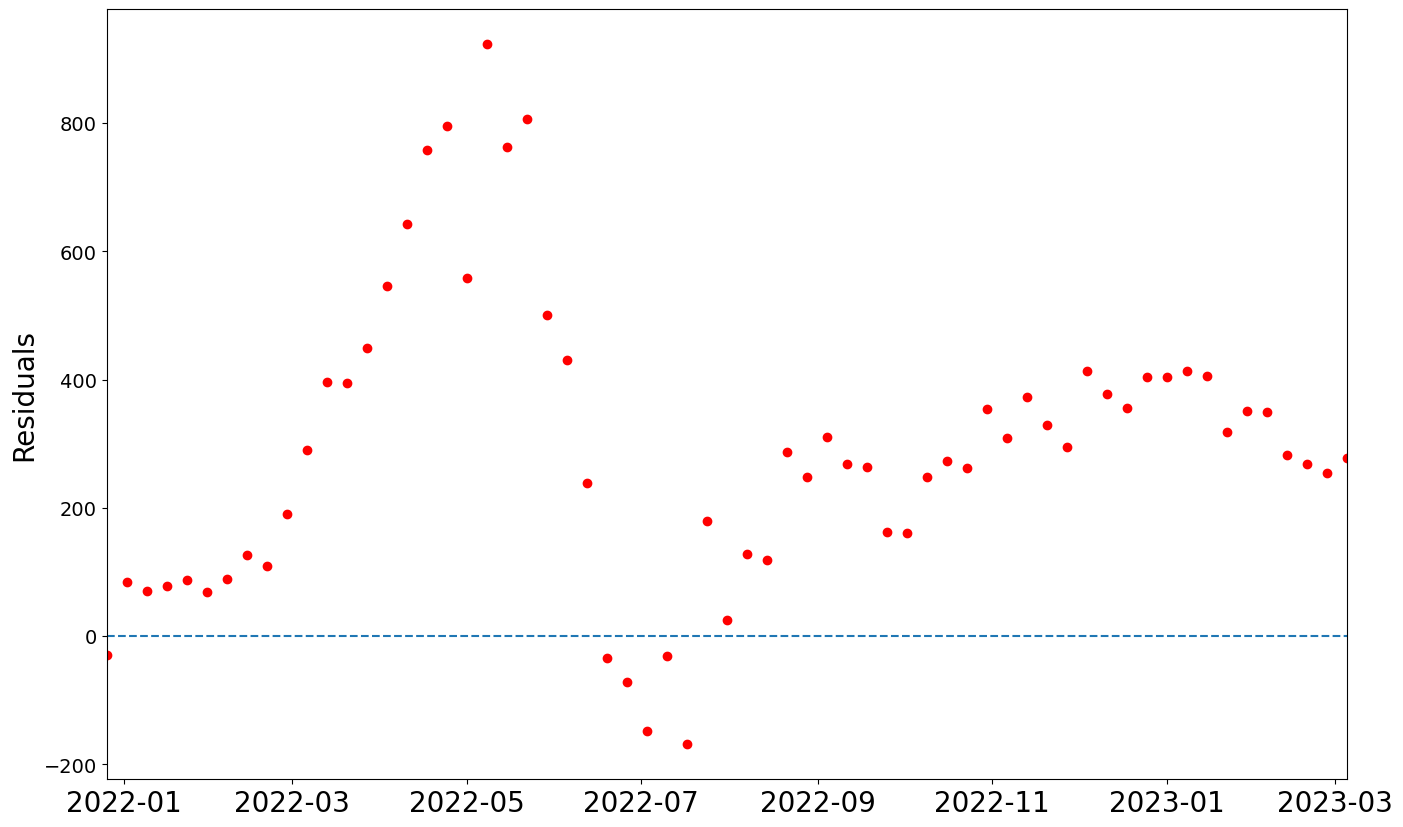

In [44]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['dengue_cases'].values - preds.values

# Generate scatterplot of residuals.
plt.scatter(test['dengue_cases'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['dengue_cases'].index.min(),
           xmax = test['dengue_cases'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['dengue_cases'].index.min(), test['dengue_cases'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

### SARIMAX Model with Exogenous Variables

In [45]:
%%time
sarimax = SARIMAX(endog=train['dengue_cases'], exog=train.drop(columns=['dengue_cases']),
                dates=train.index,
                order=(1,1,2),
                seasonal_order=(1,1,0,48),
                enforce_stationarity=False, # speed up model fitting
                enforce_invertibility=False # speed up model fitting
               )

model = sarimax.fit(maxiter=50, method='lbfgs')

preds = model.predict(start=test.index[0], end=test.index[-1],
                           exog=test.drop(columns=['dengue_cases']))

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78540D+00    |proj g|=  1.70715D-02

At iterate    5    f=  1.78137D+00    |proj g|=  1.32480D-02

At iterate   10    f=  1.77859D+00    |proj g|=  1.84350D-02

At iterate   15    f=  1.77317D+00    |proj g|=  1.80462D-02

At iterate   20    f=  1.77016D+00    |proj g|=  1.23824D-02

At iterate   25    f=  1.75107D+00    |proj g|=  1.83018D-02

At iterate   30    f=  1.73737D+00    |proj g|=  1.31901D-02

At iterate   35    f=  1.71949D+00    |proj g|=  7.97275D-03

At iterate   40    f=  1.71108D+00    |proj g|=  7.54375D-03

At iterate   45    f=  1.69999D+00    |proj g|=  4.47968D-02


/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.69029D+00    |proj g|=  6.85971D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     58      1     0     0   6.860D-03   1.690D+00
  F =   1.6902863703569191     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
CPU times: user 37.5 s, sys: 3.29 s, total: 40.8 s
Wall time: 22.3 s


/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


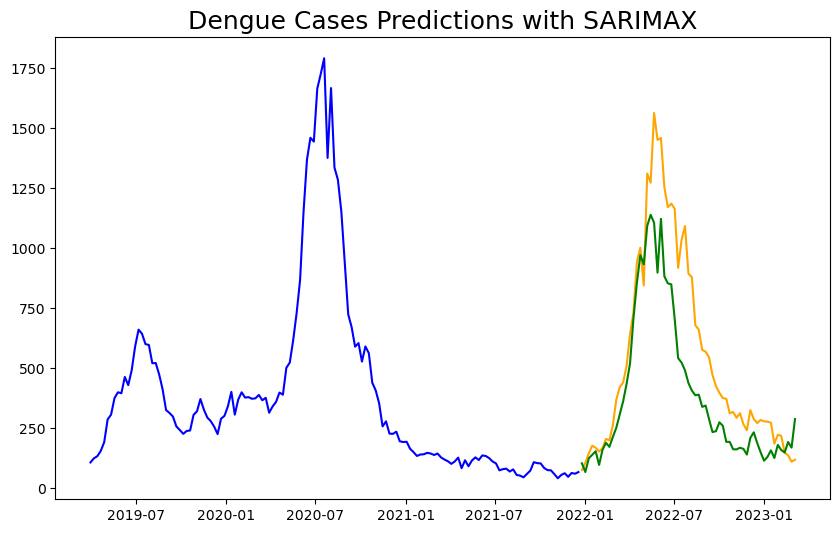

In [46]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds, color = 'green')

plt.title(label = 'Dengue Cases Predictions with SARIMAX', fontsize=18)
plt.show();

In [47]:
# Evaluate the predictions with mean error
mean_squared_error(test['dengue_cases'], preds, squared=False)

227.36623012681125

In [48]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        dengue_cases   No. Observations:                  143
Model:             SARIMAX(1, 1, 2)x(1, 1, [], 48)   Log Likelihood                -241.711
Date:                             Fri, 21 Apr 2023   AIC                            521.422
Time:                                     21:58:44   BIC                            555.748
Sample:                                 03-31-2019   HQIC                           534.219
                                      - 12-19-2021                                         
Covariance Type:                               opg                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Mean Temperature (°C)             -0.2496     21.539     -0.012      0.991     -42.465      41.965
Daily Rainfall Total (mm)          0.5174      1.663      0.311      0.756      -2.742       3.776
google_trends                      5.1204      2.790      1.835      0.067      -0.349      10.590
Mean Temperature (°C)_lag28       15.7074     20.925      0.751      0.453     -25.306      56.720
Mean Temperature (°C)_lag51       14.7765     14.000      1.055      0.291     -12.663      42.216
Mean Wind Speed (km/h)_lag6        2.8131      5.625      0.500      0.617      -8.213      13.839
Mean Wind Speed (km/h)_lag22      -4.8695      5.017     -0.971      0.332     -14.702       4.963
Mean Wind Speed (km/h)_lag47      -0.6965      5.077     -0.137      0.891     -10.646       9.253
Maximum Temperature (°C)_10        2.9438      6.343      0.464      0.643      -9.489      15.377
Maximum Temperature (°C)_lag10     2.9438      6.343      0.464      0.643      -9.489      15.377
Max Wind Speed (km/h)_lag14       -0.5860      2.011     -0.291      0.771      -4.528       3.355
Max Wind Speed (km/h)_lag41        1.2304      1.401      0.878      0.380      -1.515       3.976
Minimum Temperature (°C)_lag49     3.2392      9.759      0.332      0.740     -15.888      22.367
s_ratio                          542.5870   1567.885      0.346      0.729   -2530.411    3615.585
ar.L1                              0.7858      0.446      1.763      0.078      -0.088       1.659
ma.L1                             -0.5369      0.508     -1.057      0.290      -1.532       0.459
ma.L2                             -0.0102      0.366     -0.028      0.978      -0.728       0.708
ar.S.L48                          -0.6072      0.132     -4.609      0.000      -0.865      -0.349
sigma2                          3017.7364   1271.904      2.373      0.018     524.850    5510.623
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.94   Prob(JB):                         0.79
Heteroskedasticity (H):               0.67   Skew:                            -0.10
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.28e+21. Standard errors may be unstable.
"""

In [49]:
# Evaluate the predictions MSE
mean_squared_error(test['dengue_cases'], preds)

51695.40260207809

In [50]:
# Evaluate the predictions with mean error
mean_squared_error(test['dengue_cases'], preds, squared=False)

227.36623012681125

#### Residual Plot

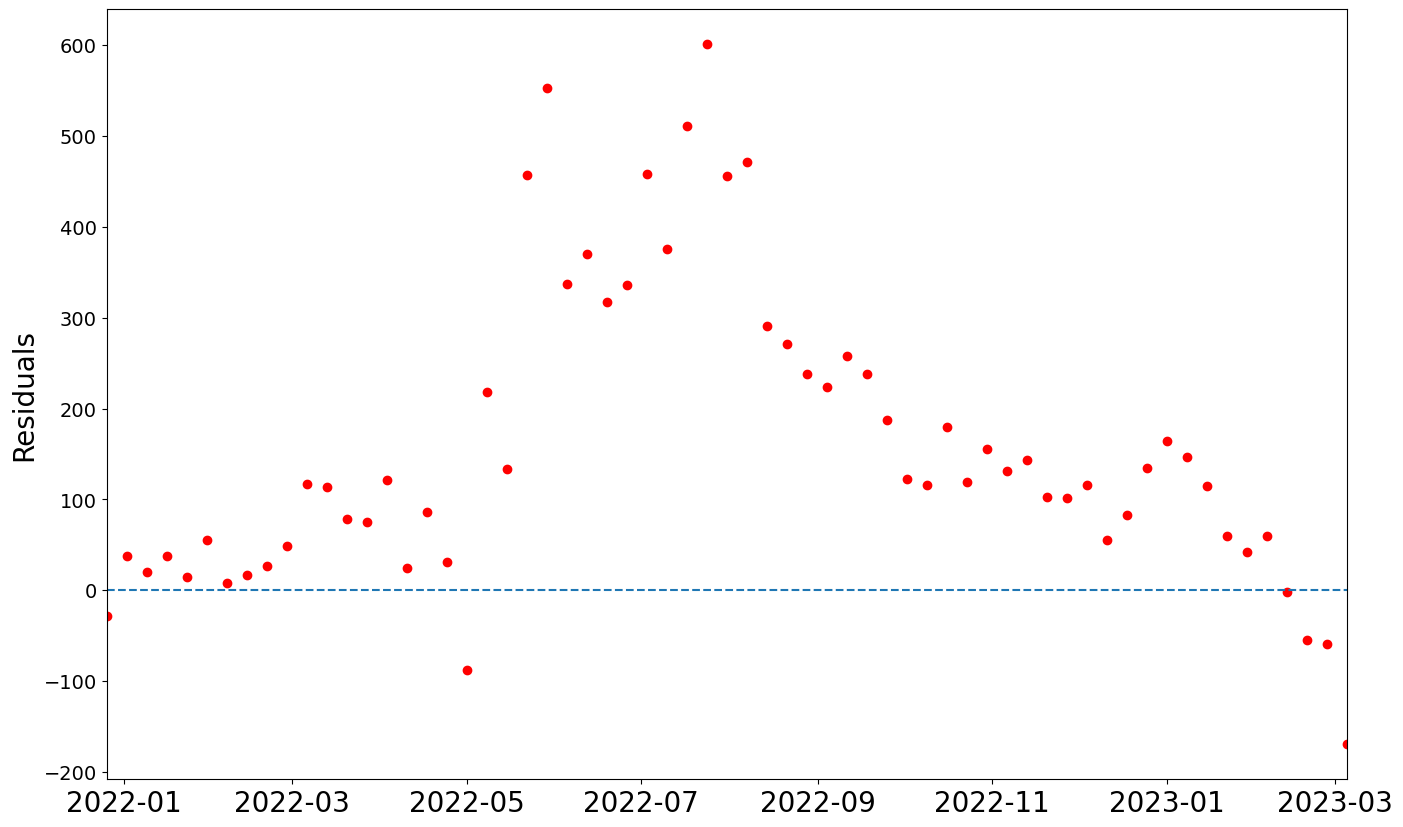

In [51]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['dengue_cases'].values - preds.values

# Generate scatterplot of residuals.
plt.scatter(test['dengue_cases'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['dengue_cases'].index.min(),
           xmax = test['dengue_cases'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['dengue_cases'].index.min(), test['dengue_cases'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

### Gradient Boosting

In [212]:
# Import the dataset
data2 = pd.read_csv('../datasets/data_features_with_lags.csv')

In [213]:
# Convert the date column into dateTime format
data2['time'] = pd.to_datetime(data2['time'])

In [214]:
# Set the time as the index
data2 = data2.set_index('time')

In [215]:
data2['dengue_cases_lag_1'] = data2['dengue_cases'].shift(1)
data2['dengue_cases_lag_2'] = data2['dengue_cases'].shift(2)
data2['dengue_cases_lag_3'] = data2['dengue_cases'].shift(3)

In [216]:
# Drop NA values
data2.dropna(inplace=True)

In [217]:
data2.drop(columns=['denv_1', 'denv_2', 'denv_3', 'denv_4'], inplace=True)

In [218]:
"""
data2.drop(columns=['month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
                   'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
                  'month_12'], inplace=True)
"""

"\ndata2.drop(columns=['month_2', 'month_3', 'month_4', 'month_5', 'month_6', \n                   'month_7', 'month_8', 'month_9', 'month_10', 'month_11',\n                  'month_12'], inplace=True)\n"

In [219]:

data2.drop(columns=['Mean Wind Speed (km/h)', 'Maximum Temperature (°C)', 
                    'Max Wind Speed (km/h)', 'Minimum Temperature (°C)'], inplace=True)


In [220]:
#data2.drop(columns=['Mean Temperature (°C)'], inplace=True)

In [221]:
"""
data2.drop(columns = ['Mean Temperature (°C)', 'Mean Temperature (°C)_lag28', 
                     'Mean Wind Speed (km/h)_lag6', 'Max Wind Speed (km/h)_lag14'
                     ], inplace=True)
"""

"\ndata2.drop(columns = ['Mean Temperature (°C)', 'Mean Temperature (°C)_lag28', \n                     'Mean Wind Speed (km/h)_lag6', 'Max Wind Speed (km/h)_lag14'\n                     ], inplace=True)\n"

In [222]:
#data2.drop(columns = ['Daily Rainfall Total (mm)'], inplace=True)

In [223]:
data2.columns

Index(['dengue_cases', 'Mean Temperature (°C)', 'Daily Rainfall Total (mm)',
       'google_trends', 'Mean Temperature (°C)_lag28',
       'Mean Temperature (°C)_lag51', 'Mean Wind Speed (km/h)_lag6',
       'Mean Wind Speed (km/h)_lag22', 'Mean Wind Speed (km/h)_lag47',
       'Maximum Temperature (°C)_10', 'Maximum Temperature (°C)_lag10',
       'Max Wind Speed (km/h)_lag14', 'Max Wind Speed (km/h)_lag41',
       'Minimum Temperature (°C)_lag49', 's_ratio', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'dengue_cases_lag_1',
       'dengue_cases_lag_2', 'dengue_cases_lag_3'],
      dtype='object')

In [224]:
train2 = data2.iloc[:143]
test2 = data2.iloc[143:]

In [225]:
X_train = train2.drop(columns=['dengue_cases'])
y_train = train2['dengue_cases']

In [226]:
X_test = test2.drop(columns=['dengue_cases'])
y_test = test2['dengue_cases']

In [227]:
# Define the Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=100, max_depth=3)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
pred = model.predict(X_test)

# Create a dataframe of the predictions
pred_df = pd.DataFrame(pred, index=y_test.index)

# Calculate the RMSE of the predictions
rmse = np.sqrt(mean_squared_error(y_test, pred))
print('RMSE:', rmse)


RMSE: 111.27004454432935


In [233]:
gb_model = GradientBoostingRegressor()
param_grid = {
    'n_estimators' : [50, 100, 150],
    'learning_rate' : [0.1, 0.05, 0.01],
    'max_depth' : [3, 5, 7],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'max_features' : [5, 15, 25, 30]
}
grid_search = GridSearchCV(gb_model, param_grid, cv=5, 
                           scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
pred = best_model.predict(X_test)
pred_df = pd.DataFrame(pred, index=y_test.index)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print('RMSE:', rmse)

RMSE: 113.43549750289269


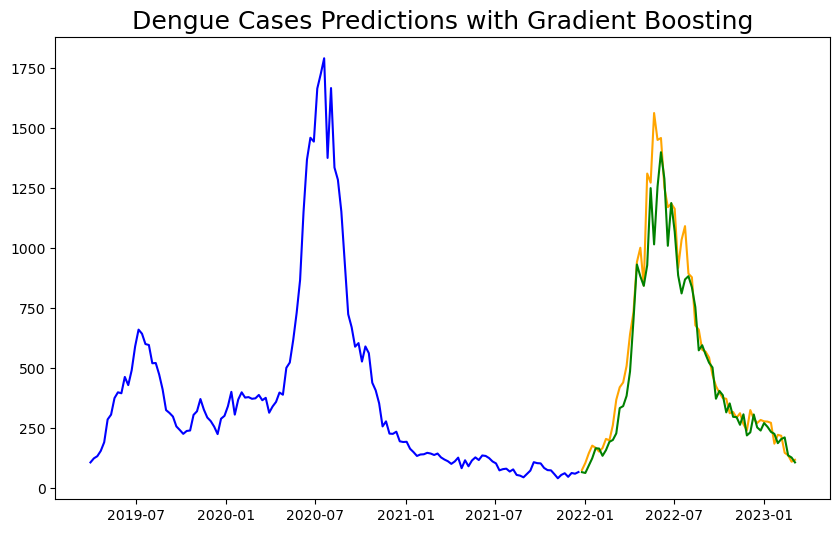

In [228]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(y_train, color = 'blue')

# Plot testing data in orange.
plt.plot(y_test, color = 'orange')

# Plot predicted values in green.
plt.plot(pred_df, color = 'green')

plt.title(label = 'Dengue Cases Predictions with Gradient Boosting', fontsize=18)
plt.show();

### Support Vector Machines

In [229]:
# Create the SVM model
svm = SVR(kernel='linear')

# Fit the SVM model on the training data
svm.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm.predict(X_test)

# Create a dataframe of the predictions
pred_df = pd.DataFrame(y_pred, index=y_test.index)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)


RMSE: 94.1905310711515


In [234]:
"""
# Define the SVM regressor model
svm_model = SVR()

# Define the hyperparameter grid to search over
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

# Define the grid search object
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    cv=5, # Use 5-fold cross-validation
    scoring='neg_root_mean_squared_error', # Use root mean squared error as the scoring metric
    n_jobs=-1 # Use all available CPU cores to speed up computation
)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
pred = best_model.predict(X_test)

# Create a dataframe of the predictions
pred_df = pd.DataFrame(y_pred, index=y_test.index)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)
"""

KeyboardInterrupt: 

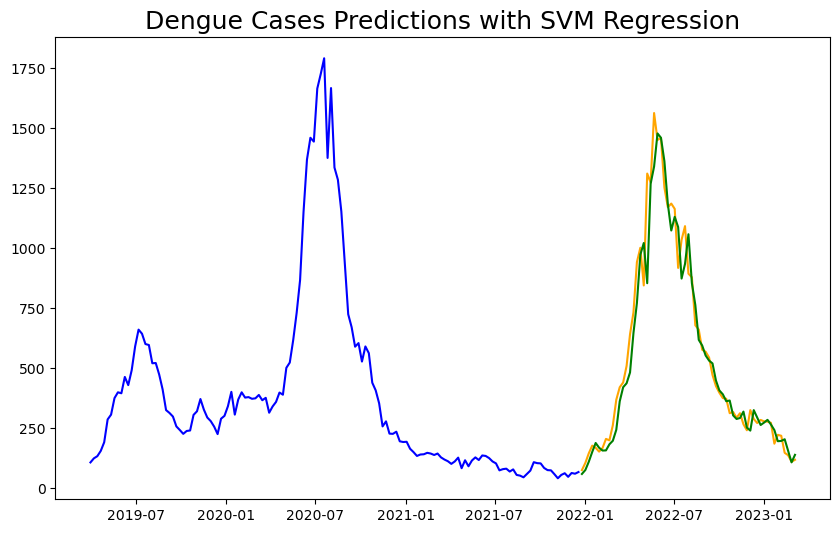

In [230]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(y_train, color = 'blue')

# Plot testing data in orange.
plt.plot(y_test, color = 'orange')

# Plot predicted values in green.
plt.plot(pred_df, color = 'green')

plt.title(label = 'Dengue Cases Predictions with SVM Regression', fontsize=18)
plt.show();

### Decision Tree and Bagging

In [231]:
# Define the base estimator
base_estimator = DecisionTreeRegressor(max_depth=3)

# Define the bagging regressor
n_estimators = 10
bagging = BaggingRegressor(base_estimator=base_estimator, n_estimators=n_estimators)

# Fit the bagging regressor on the training data
bagging.fit(X_train, y_train)

# Make predictions on the test data
pred = bagging.predict(X_test)

# Create a dataframe of the predictions
pred_df = pd.DataFrame(pred, index=y_test.index)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print('RMSE:', rmse)


RMSE: 105.44956153245639


/usr/local/Caskroom/miniconda/base/envs/dsi-sg-test/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


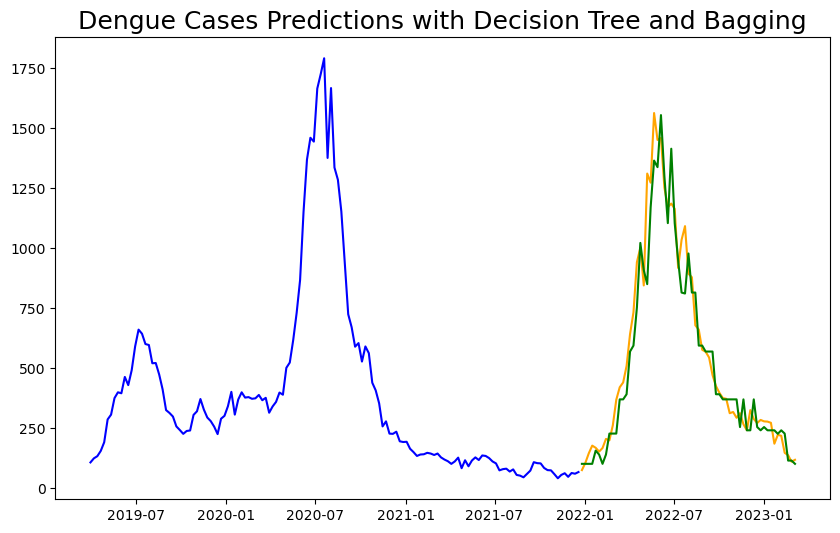

In [232]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(y_train, color = 'blue')

# Plot testing data in orange.
plt.plot(y_test, color = 'orange')

# Plot predicted values in green.
plt.plot(pred_df, color = 'green')

plt.title(label = 'Dengue Cases Predictions with Decision Tree and Bagging', fontsize=18)
plt.show();

In [211]:
import xgboost as xgb

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.01,
    objective='reg:squarederror',
    random_state=42
)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
pred = xgb_model.predict(X_test)

# Create a dataframe of the predictions
pred_df = pd.DataFrame(pred, index=y_test.index)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print('RMSE:', rmse)


RMSE: 124.9432034264635


### Auto ARIMA (not used)

In [ ]:
# Install pmdarina at your own risk. It casues a lot of issues with the dependencies. 
from pmdarima.arima import auto_arima

In [ ]:
model_auto = auto_arima(train['dengue_cases'], exogenous=train.drop(columns=['dengue_cases']), 
                       trace=True, error_action='ignore', suppress_warnings=True)

In [ ]:
# Instantiate best model.
arimax = ARIMA(endog=train['dengue_cases'], order=(1, 1, 2), 
               exog=train.drop(columns=['dengue_cases']))

# Fit ARIMA model.
model_2 = arimax.fit()

# Generate predictions based on test set.
#preds = model.predict(start=test.index[0], end = test.index[-1])
# Start at 196 instead of 195 because we took difference = 1
#preds = model.predict(start=196, end=257)
preds_auto = model_2.predict(start=196, end=256, exog=test.drop(columns=['dengue_cases']))

In [ ]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds_auto, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX(3,1,0)', fontsize=18)
plt.show();